In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LogNorm, SymLogNorm
from scipy.spatial import cKDTree
from string import ascii_lowercase

import discretize 

from simpeg import (
    maps,
    utils,
    data_misfit, 
    regularization, 
) 

import spcsem
from simpeg.electromagnetics import frequency_domain as fdem

In [4]:
Solver = utils.solver_utils.get_default_solver()

In [5]:
mesh = discretize.TreeMesh.read_UBC("../e3d/J/octree_mesh_casing.txt")
conductivity_model = discretize.TreeMesh.read_model_UBC(mesh, "../e3d/J/model_casing.con")

In [6]:
jx_e3d = np.loadtxt("../e3d/J/J_X.txt")
jy_e3d = np.loadtxt("../e3d/J/J_Y.txt")
jz_e3d = np.loadtxt("../e3d/J/J_Z.txt")

In [7]:
jx = spcsem.utils.match_values_nearest(jx_e3d, mesh.edges_x)
jy = spcsem.utils.match_values_nearest(jy_e3d, mesh.edges_y)
jz = spcsem.utils.match_values_nearest(jz_e3d, mesh.edges_z)

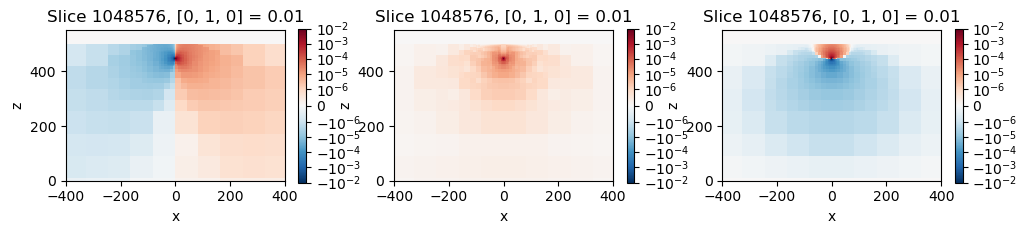

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(12, 2))

for a, j, comp in zip(ax, [jx, jy, jz], ["x", "y", "z"]): 
    cb = plt.colorbar(mesh.plot_slice(
        getattr(mesh, f"average_edge_{comp}_to_cell") * j, 
        ax=a,
        normal="y", 
        pcolor_opts={"norm":SymLogNorm(vmin=-1e-2, vmax=1e-2, linthresh=1e-6), "cmap":"RdBu_r"},
    )[0], ax=a)
    a.set_xlim(np.r_[-1, 1]*400)
    a.set_ylim(np.r_[0, 550])
    a.set_aspect(1)

In [11]:
# load predicted data 
data_path = "../e3d/points"

In [12]:
data_locs = np.loadtxt(f"{data_path}/points.txt")
data_e3d = np.loadtxt(f"{data_path}/dpredFWD.txt")

In [13]:
data_e3d_x = data_e3d[::2, :]
data_e3d_y = data_e3d[1::2, :]

In [14]:
rx_x = np.unique(data_locs[:, 0])
rx_y = np.unique(data_locs[:, 1])

In [15]:
data_locs[:, 0].reshape((len(rx_x), len(rx_y)), order="F")

array([[-75. , -72.5, -70. , ...,  70. ,  72.5,  75. ],
       [-75. , -72.5, -70. , ...,  70. ,  72.5,  75. ],
       [-75. , -72.5, -70. , ...,  70. ,  72.5,  75. ],
       ...,
       [-75. , -72.5, -70. , ...,  70. ,  72.5,  75. ],
       [-75. , -72.5, -70. , ...,  70. ,  72.5,  75. ],
       [-75. , -72.5, -70. , ...,  70. ,  72.5,  75. ]], shape=(61, 61))

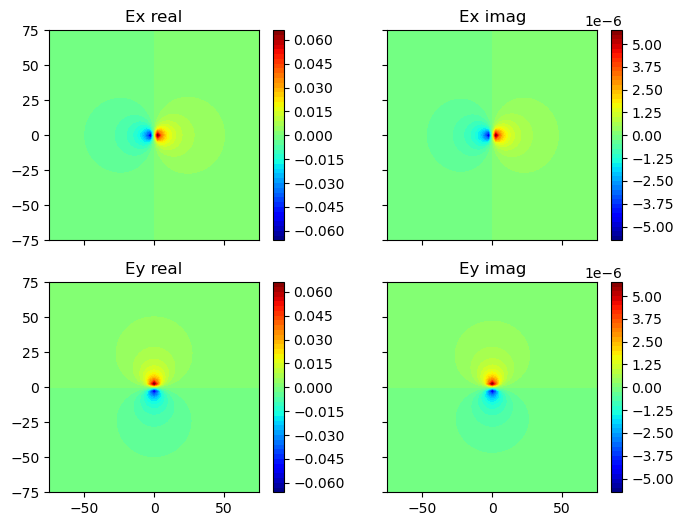

In [16]:
fig, ax = plt.subplots(2, 2, figsize=(8, 6), sharex=True, sharey=True)

for i, data_plot in enumerate([data_e3d_x, data_e3d_y]):
    for j, comp in enumerate(["real", "imag"]): 
        plt.colorbar(
            ax[i, j].contourf(
                rx_x, rx_y, data_plot[:, j].reshape(len(rx_x), len(rx_y), order="F"), levels=50,
                cmap="jet"
            ), ax=ax[i, j]
        )
        ax[i, j].set_title(f"E{ascii_lowercase[23+i]} {comp}")
for a in ax.flatten(): 
    a.set_aspect(1)

In [17]:
# setup and run simulation 

In [18]:
rx_list = [
    fdem.receivers.PointElectricField(locations=data_locs, orientation="x", component="real"),
    fdem.receivers.PointElectricField(locations=data_locs, orientation="x", component="imag"),
    fdem.receivers.PointElectricField(locations=data_locs, orientation="y", component="real"),
    fdem.receivers.PointElectricField(locations=data_locs, orientation="y", component="imag"),
]

In [19]:
gravity_acceleration = 9.81 
density_water = 1000.0 
coupling_coefficient = 1e-5

In [20]:
frequency = 1 

In [35]:
jsrc = (
    # -coupling_coefficient / (density_water*gravity_acceleration) * 
    -np.hstack([jx, jy, jz])
)

In [36]:
# source = fdem.sources.RawVec_e(
#     s_e = jsrc,
#     frequency = frequency, 
#     integrate = True,
#     receiver_list = rx_list,
# )
source = JspSource(
    receiver_list=rx_list, 
    frequency=frequency,
    pore_pressure_gradient=1/(-coupling_coefficient / (density_water*gravity_acceleration)) * jsrc,
    density_water=density_water, 
    gravity_acceleration=gravity_acceleration,
)

In [37]:
survey = fdem.Survey([source])

In [38]:
active_cells = mesh.cell_centers[:, 2] < 500, # all cells below 500m are active
coupling_coefficient_map = (
    maps.InjectActiveCells(
        mesh=mesh,
        active_cells=active_cells,
        value_inactive=0, # set coupling coefficient to 0 in air 
    ) * 
    maps.ExpMap(nP=np.sum(active_cells)) # use ExpMap to ensure value is positive
)

sim = Simulation3DElectricFieldSelfPotential(
    mesh=mesh, 
    survey=survey, 
    solver=Solver,
    sigma=conductivity_model, 
    coupling_coefficientMap=coupling_coefficient_map, 
    storeJ=True
)

In [39]:
%%time

dpred = sim.make_synthetic_data(np.log(coupling_coefficient)*np.ones(np.sum(active_cells)))

/Users/lindseyjh/miniforge3/envs/sp-csem-inv/lib/python3.11/site-packages/pymatsolver/solvers.py:415: FutureWarning: In Future pymatsolver v0.4.0, passing a vector of shape (n, 1) to the solve method will return an array with shape (n, 1), instead of always returning a flattened array. This is to be consistent with numpy.linalg.solve broadcasting.
  return self.solve(val)


CPU times: user 8min 12s, sys: 29 s, total: 8min 41s
Wall time: 1min 52s


In [40]:
dpred[source, rx_list[0]]

array([-0.00063666, -0.00067197, -0.00070757, ...,  0.00069545,
        0.00066085,  0.00062649], shape=(3721,))

In [42]:
n_stations = len(data_locs)


np.float64(0.06593231)

In [98]:
max_re = np.max(np.abs(data_e3d[:, 0]))
max_im = np.max(np.abs(data_e3d[:, 1]))
np.allclose( data_e3d_x[:, 0], dpred[source, rx_list[0]], atol=1e-3*max_re, rtol=0.03)
np.allclose(-data_e3d_x[:, 1], dpred[source, rx_list[1]], atol=1e-2*max_im, rtol=0.03)
np.allclose( data_e3d_y[:, 0], dpred[source, rx_list[2]], atol=1e-3*max_re, rtol=0.03)
np.allclose(-data_e3d_y[:, 1], dpred[source, rx_list[3]], atol=1e-2*max_im, rtol=0.03)

True

In [91]:
1e-2*max_im

np.float64(5.666983e-08)

In [92]:
1e-3*max_re

np.float64(6.593231e-05)

In [89]:
np.linalg.norm(data_e3d_x[:, 1]+dpred[source, rx_list[1]])

np.float64(1.1373382443034143e-06)

In [90]:
np.linalg.norm(data_e3d_x[:, 1])

np.float64(2.066664392382501e-05)

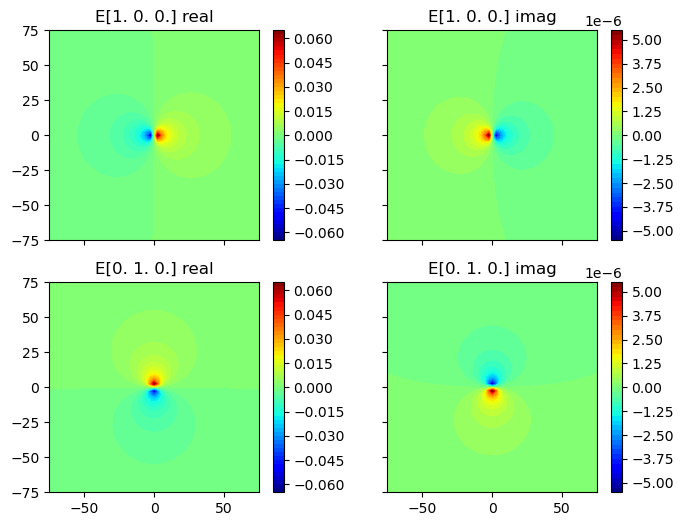

In [78]:
fig, ax = plt.subplots(2, 2, figsize=(8, 6), sharex=True, sharey=True)

for a, rx in zip(ax.flatten(), rx_list):
    plt.colorbar(
        a.contourf(
            rx_x, rx_y, dpred[source, rx].reshape(len(rx_x), len(rx_y), order="F"), levels=50,
            cmap="jet"
        ), ax=a
    )
    a.set_title(f"E{rx.orientation} {rx.component}")

    a.set_aspect(1)

# testing for the inversion

In [26]:
# dpred.relative_error=0.05
# dpred.noise_floor=1e-8

In [27]:
# phid = data_misfit.L2DataMisfit(simulation=sim, data=dpred)

In [28]:

# x0 = np.log(1e-5 + 1e-7 *np.random.randn(np.sum(active_cells)))
# # x0 = 1e-5 + 1e-7 *np.random.randn(mesh.n_cells)


# def fun(x):
#     return sim.dpred(x), lambda x: sim.Jvec(x0, x)

# discretize.tests.check_derivative(
#     fun, x0, num=2
# )

In [29]:
active_cells = mesh.cell_centers[:, 2] < 500, # all cells below 500m are active
coupling_coefficient_map_complex = (
    maps.InjectActiveCells(
        mesh=mesh,
        active_cells=active_cells,
        value_inactive=0, # set coupling coefficient to 0 in air 
    ) * 
    maps.ComplexMap(nP=np.sum(active_cells)*2) *
    maps.ExpMap(nP=np.sum(active_cells)*2) # use ExpMap to ensure value is positive
)

sim2 = Simulation3DElectricFieldSelfPotential(
    mesh=mesh, 
    survey=survey, 
    solver=Solver,
    sigma=conductivity_model, 
    coupling_coefficientMap=coupling_coefficient_map_complex, 
    storeJ=True
)

In [30]:
x0 = np.hstack([
    np.log(1e-10*(1e-5 + 1e-7 *np.random.randn(np.sum(active_cells)))),
    np.log((1e-6 + 1e-8 * np.random.randn(np.sum(active_cells))))
])
coupling_coefficient_map_complex.test(x0)

Testing ComboMap[ComboMap[InjectActiveCells(211544,125652) * ComplexMap(125652,251304)](211544,251304) * ExpMap(251304,251304)](211544,251304)
==================== check_derivative ====================
iter    h         |ft-f0|   |ft-f0-h*J0*dx|  Order
---------------------------------------------------------
 0   1.00e-01    3.566e-05     3.082e-06      nan
 1   1.00e-02    3.535e-06     3.060e-08      2.003
 2   1.00e-03    3.534e-07     3.059e-10      2.000
 3   1.00e-04    3.534e-08     3.059e-12      2.000
========================= PASS! =========================
Not just a pretty face Lindseyjh



True

In [31]:


# x0 = 1e-5 + 1e-7 *np.random.randn(mesh.n_cells)


def fun2(x):
    return sim2.dpred(x), lambda x: sim2.Jvec(x0, x)

discretize.tests.check_derivative(
    fun2, x0, num=2
)

==================== check_derivative ====================
iter    h         |ft-f0|   |ft-f0-h*J0*dx|  Order
---------------------------------------------------------


/Users/lindseyjh/miniforge3/envs/sp-csem-inv/lib/python3.11/site-packages/pymatsolver/solvers.py:415: FutureWarning: In Future pymatsolver v0.4.0, passing a vector of shape (n, 1) to the solve method will return an array with shape (n, 1), instead of always returning a flattened array. This is to be consistent with numpy.linalg.solve broadcasting.
  return self.solve(val)


 0   1.00e-01    1.517e-04     1.631e-04      nan
 1   1.00e-02    9.595e-06     1.630e-06      2.000
========================= PASS! =========================
You get a gold star!



True

In [ ]:
x0 = 1e-5*np.ones(mesh.n_cells)
sim.model=x0
a = source.s_e(sim)
np.unique(sim.coupling_coefficient)

In [ ]:
sim.model = x0*10
b = source.s_e(sim)

In [ ]:
np.unique(sim.coupling_coefficient)

In [ ]:
np.unique(a-b)

In [ ]:

# x0 = 1e-5 + 1e-7 * np.random.randn(np.sum(active_cells))

x0 = 1e-5 + 1e-7 * np.random.randn(mesh.n_cells)

def fun(x):
    sim.model = x0
    return source.s_e(sim), lambda x: source.s_eDeriv(sim, x)

discretize.tests.check_derivative(
    fun, x0, num=2
)

In [54]:
n = 10
A = np.random.rand(n, n)

def fun(x): 
    return A@x, lambda v: A@v

discretize.tests.check_derivative(
    fun, np.random.randn(n), num=2
)

==================== check_derivative ====================
iter    h         |ft-f0|   |ft-f0-h*J0*dx|  Order
---------------------------------------------------------
 0   1.00e-01    2.333e-01     2.088e-15      nan
 1   1.00e-02    2.333e-02     1.929e-15      0.035
========================= PASS! =========================
Yay passed!



True

In [ ]:
import simpeg
simpeg.Report()